In [1]:
!pip install -U d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
 

In [2]:
!pip install IPython

In [3]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms
from d2l import torch as d2l
from IPython import display
import math

d2l.use_svg_display()

In [4]:
batch_size = 256

In [5]:
# MNIST Dataset
train_iter = datasets.KMNIST(root='./mnist_data/',train=True,transform=transforms.ToTensor(),download=True)

test_iter = datasets.KMNIST(root='./mnist_data/',train=False,transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_iter,batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_iter,batch_size=batch_size,shuffle=False)


100%|██████████| 18165135/18165135 [00:08<00:00, 2144062.66it/s]


Extracting ./mnist_data/KMNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 352761.30it/s]


Extracting ./mnist_data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:01<00:00, 1616686.21it/s]


Extracting ./mnist_data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 23116078.02it/s]

Extracting ./mnist_data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/KMNIST/raw



In [6]:
def get_kmnist_labels(labels):
  """return text labels for Fashion MNIST dataset"""
  text_labels = ['o', 'ki', 'su', 'tsu', 'na',
                 'ha', 'ma','ya', 're', 'wo']
  return [text_labels[int(i)] for i in labels]


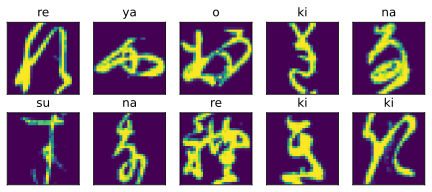

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  """create a function to visualize these samples"""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize) # return a tuple contains figure and axes
  axes = axes.flatten() # expand subplot and assign value to axes

  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      ax.imshow(img.numpy())
    else:
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False) # hide x coordinate axis
    ax.axes.get_yaxis().set_visible(False) # hide y coordinate axis
    if titles:
      ax.set_title(titles[i])
  return axes

X, y = next(iter(data.DataLoader(train_iter, batch_size =10)))
show_images(X.reshape(10, 28, 28), 2, 5, titles = get_kmnist_labels(y));

In [8]:
num_inputs = 784
num_outputs = 10
std = 0.01

W = torch.normal(0, std, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [9]:
len(train_loader)

235

In [10]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [11]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [12]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [13]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [14]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [15]:
class Accumulator:
  """For accumulating sums over `n` variables."""
  def __init__(self, n):
    self.data = [0.0] * n
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  def reset(self):
    self.data = [0.0] * len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]

In [16]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [17]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [18]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')#

In [19]:
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

loss 0.590, train acc 0.826, test acc 0.696


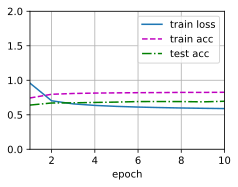

In [20]:
#cross entropy
lr = 0.1
num_epochs = 10
train_ch3(net, train_loader, test_loader, cross_entropy, num_epochs, updater)

loss 1.312, train acc 0.707, test acc 0.547


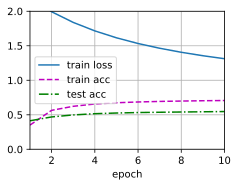

In [20]:
#cross entropy with different learning rate
lr = 0.001
num_epochs = 10
train_ch3(net, train_loader, test_loader, cross_entropy, num_epochs, updater)

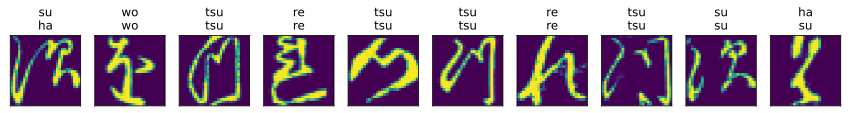

In [41]:
#visualize 10 result

def predict_ch3(net, test_iter, n=10):
  for X, y in test_iter:
    break
  trues = get_kmnist_labels(y)
  preds = get_kmnist_labels(net(X).argmax(axis=1))
  titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(
    X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_loader)


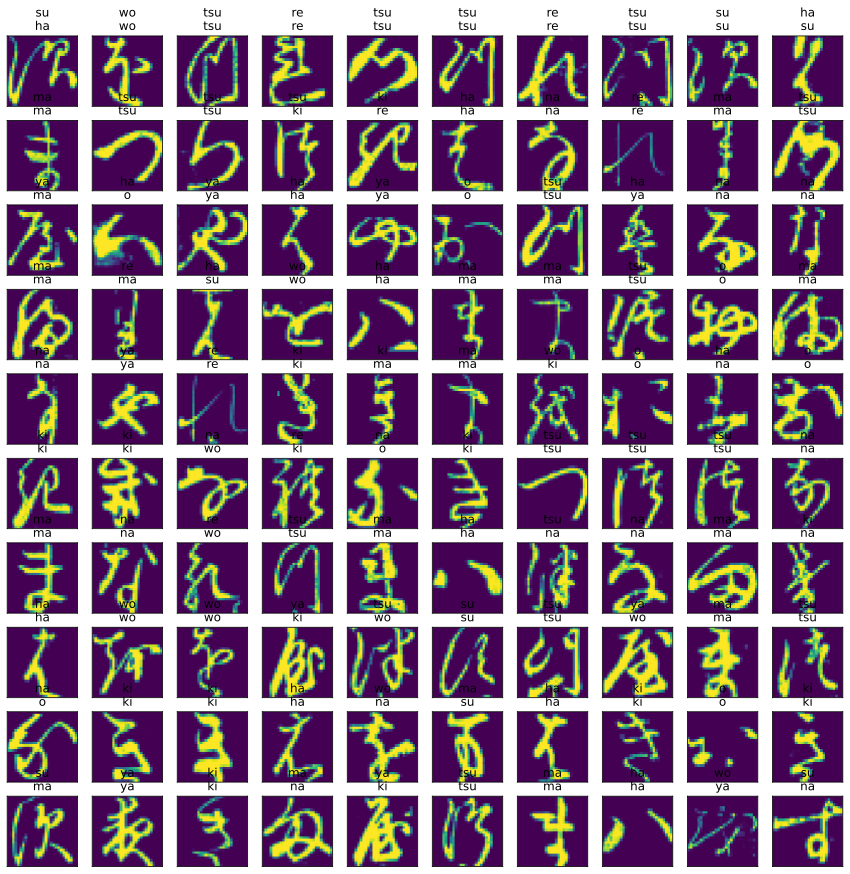

In [42]:
#visualize 100 result

def predict_ch3(net, test_iter, n=100):
  for X, y in test_iter:
    break
  trues = get_kmnist_labels(y)
  preds = get_kmnist_labels(net(X).argmax(axis=1))
  titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(
    X[0:n].reshape((n, 28, 28)), int(math.sqrt(n)), int(math.sqrt(n)), titles=titles[0:n])

predict_ch3(net, test_loader)